# Integrated droplet rig

As an extension to the document "Semrock multiedge dichroic summary", we further consider the (spectral) effects of using a broadband source on signal, crosstalk and leakage. 

*There is currently no provision made for changes in etendue linked to the use of an extended source as opposed to a laser source; nor is there any consideration of the additional elements that may be necessary in the optical path for integration into a DMD rig, particularly beamsplitter cubes and plates.* 

Educated guesses have been made to choose a filterset that improves on the performance afforded by the current standard filterset when used in conjunction with a multiedge dichroic - in particular, changes have been made to the 633 and 700 filtersets. The entire Semrock and Chroma catalogues may be scraped from the web using the scrapers in .\semrock-scraper and .\chroma-scraper respectively. If a suitable scoring metric can be decided upon giving appropriate weight to signal, crosstalk and leakage, then it is intended that it might be possible to land on a more optimal filterset. 


__Sources for dye data:__

Atto general properties: https://www.atto-tec.com/fileadmin/user_upload/Katalog_Flyer_Support/Dye_Properties_01.pdf

Atto spectra: https://www.atto-tec.com/attotecshop/product_info.php?language=en&info=p117_ATTO-700.html

Alexa 405 absorption coefficient: http://www.atdbio.com/content/34/Alexa-dyes

Alexa 405 QY: http://confocal-microscopy-list.588098.n2.nabble.com/alexa-405-QY-td6913848.html

Alexa 405 spectra: https://www.chroma.com/spectra-viewer?fluorochromes=10533


__Sources for filter spectra:__

Semrock filters: http://www.laser2000.co.uk

Chroma 700 dichroics: emailed from Chroma

General Chroma filters: https://www.chroma.com/products/


__Sources for camera spectra:__

Andor Zyla 5.5: https://searchlight.semrock.com/


__Sources for optics (objective) spectra:__

Olympus UPLANSAPO20x: https://www.olympus-lifescience.com/en/objectives/uplsapo/#!cms[tab]=%2Fobjectives%2Fuplsapo%2F20x, data extracted from curve using WebPlotDigitiser: http://arohatgi.info/WebPlotDigitizer/app/

Nikon CFI SuperFluor 10x 0.5 NA: https://www.nikoninstruments.com/en_GB/Product-Selectors/Objective-Comparison/(items)/i28, data extracted using WebPlotDigitiser. 


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from dye import Dye
from laser import Laser
from filterCube import FilterCube
from interferenceFilter import InterferenceFilter
from broadbandSource import BroadbandSource
from camera import Camera
from objective import Objective
import utils
from crosstalk_analysis import signalFromDyeXInChannelY
from crosstalk_analysis import displayCrosstalkPlot
from crosstalk_analysis import calcLeakage
from crosstalk_analysis import showDyeEmissionEnclosedByFilters

dyesPath = 'Dye spectra/'
filtersPath = 'Filter spectra/'
opticsPath =  'Optics spectra/'
cameraPath = 'Camera spectra/'
sourcesPath = 'Source spectra/'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Dyes

In [2]:
dye405 = Dye(name = 'Alexa405', epsilon = 35000, qy = 0.54, 
             absSpectrum = os.path.join(dyesPath, 'Alexa405abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'Alexa405em.txt'))
          
dye532 = Dye(name = 'Atto532', epsilon = 115000, qy = 0.9, 
             absSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO532_PBS.ems.txt'))

dye594 = Dye(name = 'Atto594', epsilon = 120000, qy = 0.85, 
             absSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.abs.txt'), 
             emSpectrum = os.path.join(dyesPath, 'ATTO594_PBS.ems.txt'))

dye633 = Dye(name = "Atto655", epsilon = 125000, qy = 0.3, 
          absSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO655_PBS.ems.txt') )        

dye700 = Dye(name = "Atto700", epsilon = 120000, qy = 0.25, 
          absSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.abs.txt'), 
          emSpectrum = os.path.join(dyesPath, 'ATTO700_PBS.ems.txt') )   

dyes = [dye405, dye532, dye594, dye633, dye700]

### Light sources

In [3]:
l405 = Laser(channel = 'L405Nm', centreWavelengthNm = 405, fwhmNm = 0.01, 
             laserOutputPowerMw = 3)
             
l532 = Laser(channel = 'L532Nm', centreWavelengthNm = 532, fwhmNm = 0.01, 
             laserOutputPowerMw = 18)
             
l594 = Laser(channel = 'L594Nm', centreWavelengthNm = 594, fwhmNm = 0.01, 
             laserOutputPowerMw = 25)             
          
l633 = Laser(channel = 'L633Nm', centreWavelengthNm = 640, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
          
l700 = Laser(channel = 'L700Nm', centreWavelengthNm = 701, fwhmNm = 0.01, 
             laserOutputPowerMw = 30)
             
lasers = [l405, l532, l594, l633, l700]

bb = BroadbandSource(name='Thorlabs HPLS343, 3mm LLG', 
                     integratedPowermW=4000.0, 
                     spectrum=os.path.join(sourcesPath, 'Thorlabs Plasma Source.txt'))
source = [bb, bb, bb, bb, bb]

### Camera
For now, use an Andor Zyla 5.5 camera on the rig to give best performance of the cameras we have instantly available - this is an expensive option that could do with revisiting. 

In [4]:
camera = Camera(name = 'Andor Zyla 5.5', 
                qeCurve = os.path.join(cameraPath, 'Camera sCMOS (Andor- Zyla 5.5).txt'), 
                sensorSizeXYMm = (14.0, 16.6), 
                sensorSizeXYPix = (2560, 2160))


### Objective

In [5]:
objective = Objective(name = 'Olympus UPLANSAPO20x 0.75NA', 
                      transmissionCurve = os.path.join(opticsPath, 'Olympus UPLANSAPO20x.txt'))

objective10x = Objective(name = 'Nikon CFI SFluor 10x 0.5 NA', 
                      transmissionCurve = os.path.join(opticsPath, 'Nikon CFISuperFluor10x.txt'))

## Existing system filter cube system

In [6]:
fc405 = FilterCube(channel = 'L405Nm', 
                   excitationFilter = ( 'FF01-390_40', os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R405', os.path.join(filtersPath, 'Di02-R405_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )
                   
fc532 = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R532', os.path.join(filtersPath, 'Di02-R532_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) )
                   
fc594 = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R594', os.path.join(filtersPath, 'Di02-R594_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-647_57', os.path.join(filtersPath, 'FF01-647_57_Spectrum.txt') ) )
             
fc633 = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'FF01-640_14', os.path.join(filtersPath, 'FF01-640_14_spectrum.txt') ), 
                   dichroicFilter = ( 'Di02-R635', os.path.join(filtersPath, 'Di02-R635_Spectrum.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                                      
fc700 = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-692_40', os.path.join(filtersPath, 'FF01-692_40_Spectrum.txt') ), 
                   dichroicFilter = ( '725lpxr', os.path.join(filtersPath, 'Chroma 725lpxr.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )

fc_current = [fc405, fc532, fc594, fc633, fc700]

## Multiedge filter system

Here we put together the set of filters to be distributed across excitation and emission filter wheels together with a single multiedge dichroic. 

(350, 800)

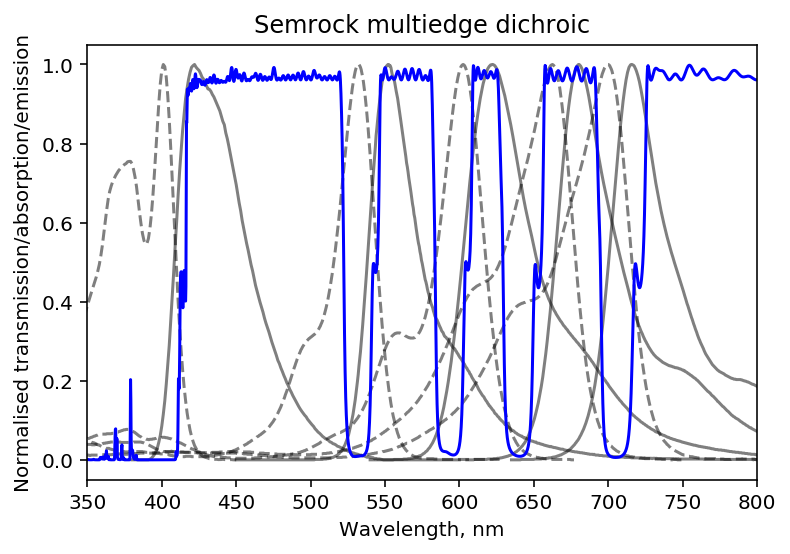

In [7]:
fc405multi = FilterCube(channel = 'L405Nm', 
                   excitationFilter = ( 'FF01-390_40', os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ),  
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )
                   
fc532multi = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ),  
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) )
                   
fc594multi = FilterCube(channel = 'L594Nm', 
                   excitationFilter = ( 'FF01-591_6', os.path.join(filtersPath, 'FF01-591_6_Spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ),  
                   emissionFilter = ( 'FF01-647_57', os.path.join(filtersPath, 'FF01-647_57_Spectrum.txt') ) )
             
fc633multi = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'LD01-640_8', os.path.join(filtersPath, 'LD01-640_8_spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) )
                   
fc700multi = FilterCube(channel = 'L700Nm', 
                   excitationFilter = ( 'FF01-700_13', os.path.join(filtersPath, 'FF01-700_13_Spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ), 
                   emissionFilter = ( 'FF01-747_33', os.path.join(filtersPath, 'FF01-747_33_Spectrum.txt') ) )

fc_multi = [fc405multi, fc532multi, fc594multi, fc633multi, fc700multi]

hfig = plt.figure()
for d in dyes:
    plt.plot(d.absorptionSpectrum[:,0], d.absorptionSpectrum[:,1], 'k--', alpha=0.5)
    plt.plot(d.emissionSpectrum[:,0], d.emissionSpectrum[:,1], 'k-', alpha=0.5)
    
plt.plot(fc405multi.dichroicFilter.getSpectrum()[:,0], fc405multi.dichroicFilter.getSpectrum()[:,1], 'b-')
plt.title('Semrock multiedge dichroic')
plt.ylabel('Normalised transmission/absorption/emission')
plt.xlabel('Wavelength, nm')
plt.xlim((350, 800))

### Signal compared to current scan rig

Signal ratio in channel L405Nm = 42.214
Signal ratio in channel L532Nm = 2.533
Signal ratio in channel L594Nm = 1.452
Signal ratio in channel L633Nm = 1.606
Signal ratio in channel L700Nm = 1.407


(0, 3)

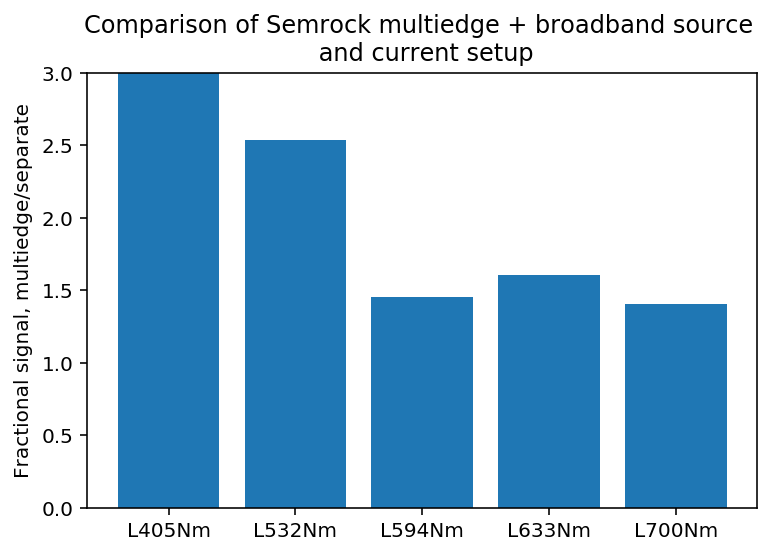

In [8]:
ratios_sem = []
ch_labels = []

for l, s, f_old, f_new, dy in zip(lasers, source, fc_current, fc_multi, dyes):
    d, ch, sig_new = signalFromDyeXInChannelY(s, f_new, dy, objective, camera)
    d, ch, sig_old = signalFromDyeXInChannelY(l, f_old, dy, objective, camera)
    
    ratios_sem.append(sig_new/sig_old)
    ch_labels.append(ch)
    print('Signal ratio in channel {} = {:0.3f}'.format(ch, (sig_new/sig_old)))

#     ol1 = show_dye_emission_enclosed_by_filters(dy, f_old, objective, camera, title='Separate dichroics')
#     ol2 = show_dye_emission_enclosed_by_filters(dy, f_new, objective, camera, title='Multiedge dichroic')

    
fig1 = plt.figure()
plt.bar([1, 2, 3, 4, 5], 
        ratios_sem, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Fractional signal, multiedge/separate')
plt.title('Comparison of Semrock multiedge + broadband source \n '+
          'and current setup')
plt.ylim([0, 3])

### Crosstalk compared to current scan rig

C:\Users\d.kelly\Documents\DyeAnalysis\crosstalk_analysis.py:96: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(crosstalkMatrix), cmap = 'Reds', interpolation='none')


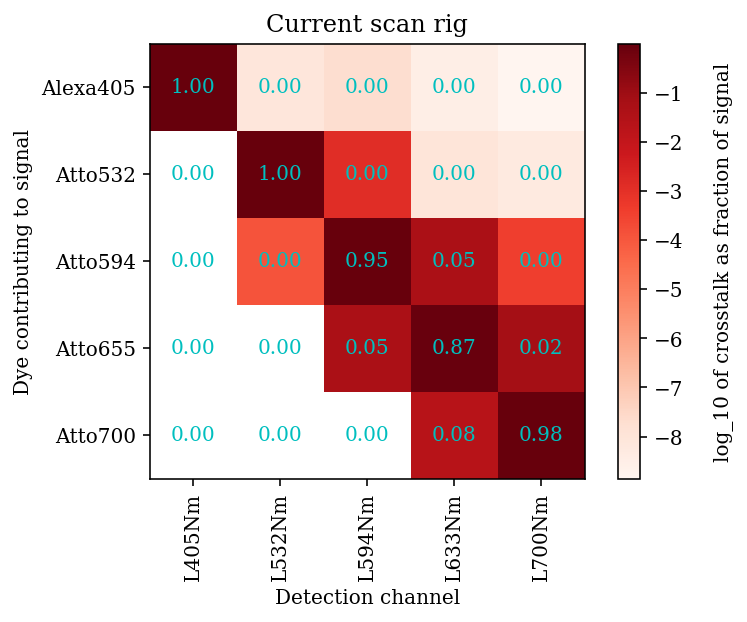

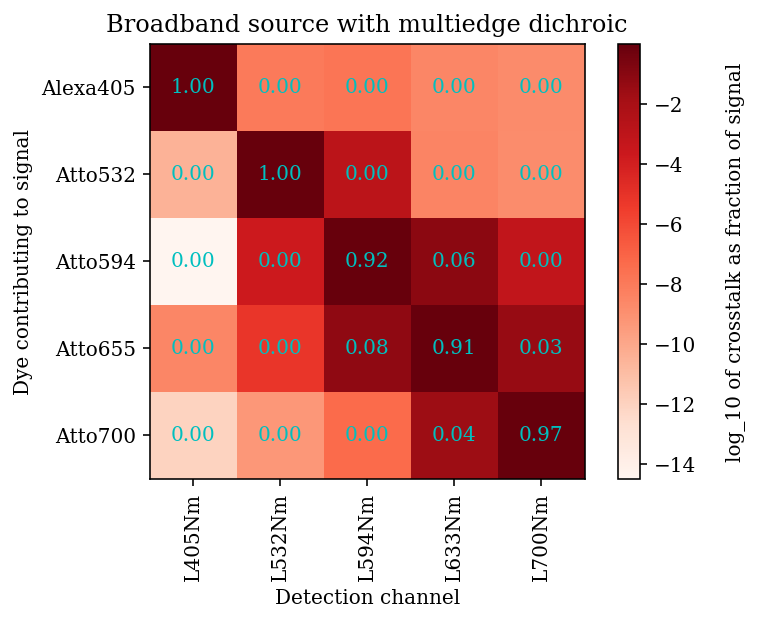

array([[  9.99999969e-01,   9.86689314e-09,   1.62304758e-08,
          2.86097380e-09,   1.86852239e-09],
       [  3.37894648e-11,   9.98850407e-01,   1.14958761e-03,
          3.42238171e-09,   1.69163702e-09],
       [  3.26659603e-15,   1.86200759e-04,   9.19880361e-01,
          7.93116365e-02,   6.21801606e-04],
       [  3.14932616e-09,   6.25926639e-06,   5.95671857e-02,
          9.05185793e-01,   3.52407592e-02],
       [  9.06515778e-13,   4.80319492e-10,   4.53947112e-08,
          2.57088053e-02,   9.74291149e-01]])

In [9]:
displayCrosstalkPlot(lasers, 
                     fc_current, 
                     dyes, 
                     objective, 
                     camera, 
                     title="Current scan rig")

displayCrosstalkPlot(source, 
                     fc_multi, 
                     dyes, 
                     objective, 
                     camera, 
                     title="Broadband source with multiedge dichroic")


## Leakage compared to current scan rig

Implicit assumptions:
* All excitation that gets to the sample plane is efficiently backscattered - i.e. sample plane is a mirror. Might not be so far removed from reality for large changes in refractive index? 
* Backscattered light is spread uniformly over detector area. 

Best to consider this a comparison rather than giving absolute numbers? Try converting to photons incident on a camera pixel per second - *watch out for factors of 10 in units (mW and nm)!*. 

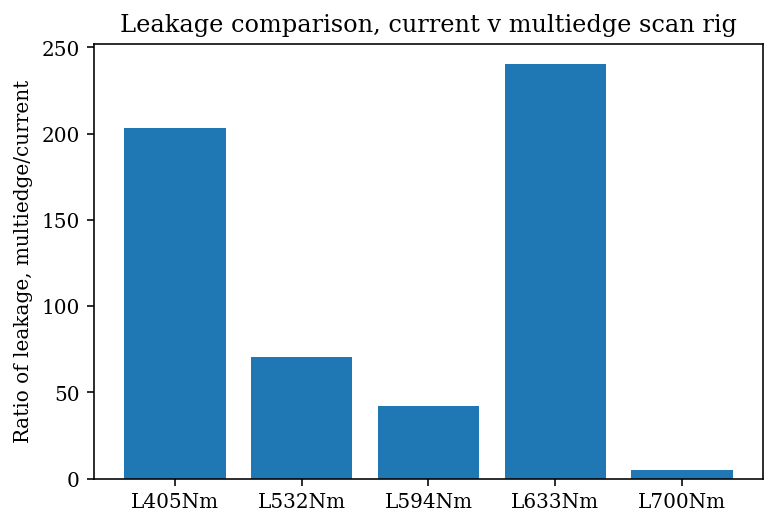

In [10]:
absolute_current_leak = [calcLeakage(sr, fc, objective) for sr, fc in zip(lasers, fc_current)]
absolute_multiedge_leak = [calcLeakage(sr, fc, objective) for sr, fc in zip(source, fc_multi)]
leak_ratio = [(ml/cl) for cl, ml in zip(absolute_current_leak, absolute_multiedge_leak)]
fig4 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        leak_ratio, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Ratio of leakage, multiedge/current')
plt.title('Leakage comparison, current v multiedge scan rig')
plt.show()

[83.797562271464869, 330.70681081923465, 45.513794219655992, 148.87336239792208, 26.093043488427305]


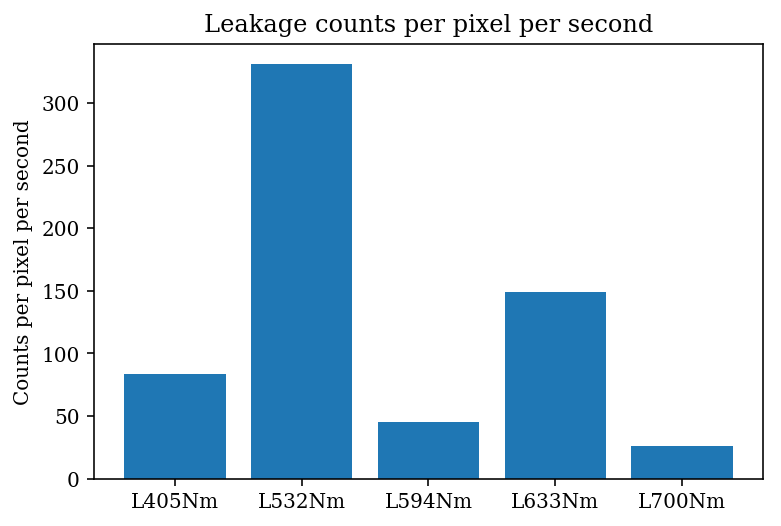

In [11]:
h = 6.626E-34
c = 2.99E8

photon_multiedge_leak = [1E-3 * leak/(h*c/(lsr.centreWavelengthNm * 1E-9)) for leak, lsr in zip(absolute_multiedge_leak, lasers)]
photons_per_pixel_per_second_multiedge_leak = [lk/(camera.sensorSizeXYPix[0] * camera.sensorSizeXYPix[1]) 
                                               for lk in photon_multiedge_leak]
counts_per_pixel_per_second = [camera.ADUperE * camera.getQEValue(lsr.centreWavelengthNm) * lk 
                               for lk, lsr in zip(photons_per_pixel_per_second_multiedge_leak, lasers)]
print(counts_per_pixel_per_second)
fig5 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        counts_per_pixel_per_second, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Counts per pixel per second')
plt.title('Leakage counts per pixel per second')
plt.show()

This looks problematic. One approach might be to double stack filters - either duplicating them, or crossing filters to narrow bands beyond what is accessible off-the-shelf from Semrock/Chroma. 

FF01-390_18+FF01-390_40


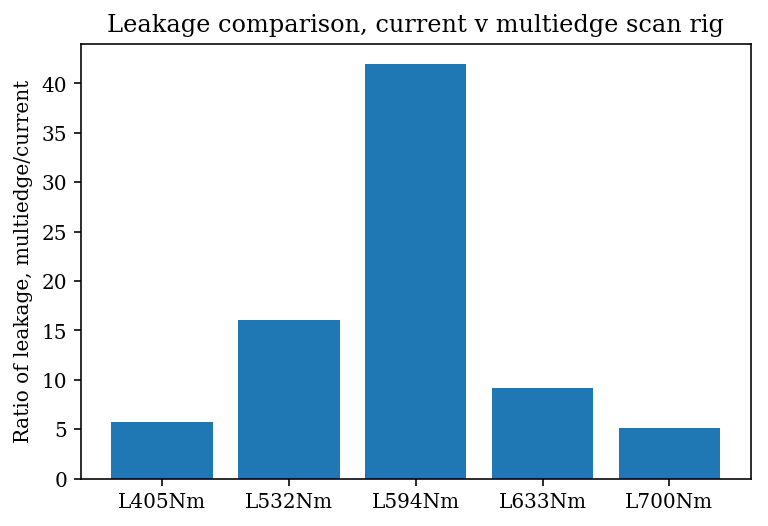

[2.3465062044694918, 75.064457541135809, 45.513794219655992, 5.6769556440462647, 26.093043488427305]


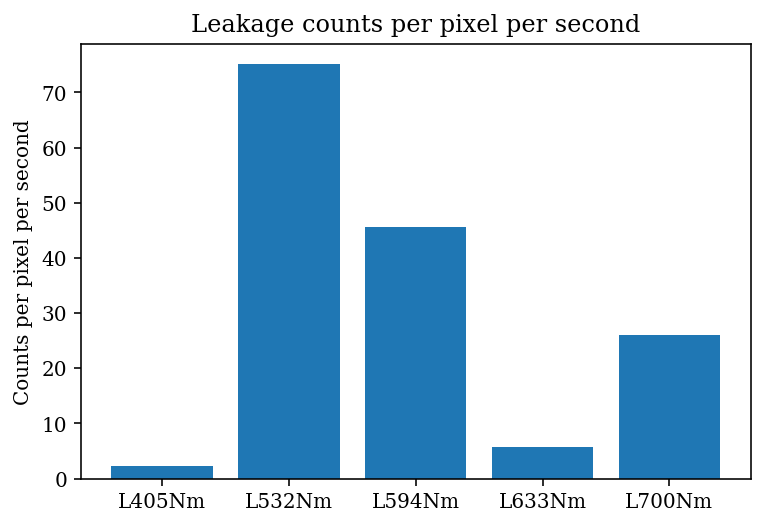

In [14]:
stacked405ex = InterferenceFilter(['FF01-390_18', 'FF01-390_40'], 
                                  [os.path.join(filtersPath, 'FF01-390_18_Spectrum.txt'), 
                                  os.path.join(filtersPath, 'FF01-390_40_Spectrum.txt')])
print(stacked405ex.name)
fc405multiDouble = FilterCube(channel = 'L405Nm', 
                   excitationFilter = stacked405ex, 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ),  
                   emissionFilter = ( 'FF01-452_45', os.path.join(filtersPath, 'FF01-452_45_Spectrum.txt') ) )

fc532multiDouble = FilterCube(channel = 'L532Nm', 
                   excitationFilter = ( 'FF01-532_3', os.path.join(filtersPath, 'FF01-532_3_spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ),  
                   emissionFilter = ( 'FF01-562_40', os.path.join(filtersPath, 'FF01-562_40_spectrum.txt') ) , 
                   doubleStackExcitation = True)
fc633multiDouble = FilterCube(channel = 'L633Nm', 
                   excitationFilter = ( 'LD01-640_8', os.path.join(filtersPath, 'LD01-640_8_spectrum.txt') ), 
                   dichroicFilter = ( 'Semrock multiedge', os.path.join(filtersPath, 'Semrock theoretical multiedge.txt') ), 
                   emissionFilter = ( 'FF01-679_41', os.path.join(filtersPath, 'FF01-679_41_Spectrum.txt') ) ,
                   doubleStackExcitation = True)

fc_multiDouble = [fc405multiDouble, fc532multiDouble, fc594multi, fc633multiDouble, fc700multi]

absolute_current_leak = [calcLeakage(sr, fc, objective) for sr, fc in zip(lasers, fc_current)]
absolute_multiedge_leak = [calcLeakage(sr, fc, objective) for sr, fc in zip(source, fc_multiDouble)]
leak_ratio = [(ml/cl) for cl, ml in zip(absolute_current_leak, absolute_multiedge_leak)]
fig4 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        leak_ratio, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Ratio of leakage, multiedge/current')
plt.title('Leakage comparison, current v multiedge scan rig')
plt.show()

photon_multiedge_leak = [1E-3 * leak/(h*c/(lsr.centreWavelengthNm * 1E-9)) for leak, lsr in zip(absolute_multiedge_leak, lasers)]
photons_per_pixel_per_second_multiedge_leak = [lk/(camera.sensorSizeXYPix[0] * camera.sensorSizeXYPix[1]) 
                                               for lk in photon_multiedge_leak]
counts_per_pixel_per_second = [camera.ADUperE * camera.getQEValue(lsr.centreWavelengthNm) * lk 
                               for lk, lsr in zip(photons_per_pixel_per_second_multiedge_leak, lasers)]
print(counts_per_pixel_per_second)
fig5 = plt.figure();
plt.bar([1, 2, 3, 4, 5], 
        counts_per_pixel_per_second, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Counts per pixel per second')
plt.title('Leakage counts per pixel per second')
plt.show()

Signal ratio in channel L405Nm = 21.433
Signal ratio in channel L532Nm = 2.400
Signal ratio in channel L594Nm = 1.452
Signal ratio in channel L633Nm = 1.509
Signal ratio in channel L700Nm = 1.407


(0, 3)

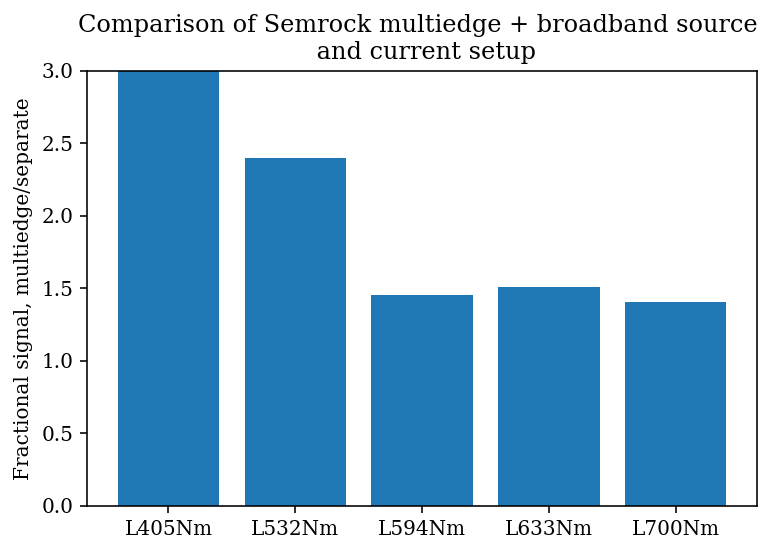

In [13]:
ratios_sem = []
ch_labels = []

for l, s, f_old, f_new, dy in zip(lasers, source, fc_current, fc_multiDouble, dyes):
    d, ch, sig_new = signalFromDyeXInChannelY(s, f_new, dy, objective, camera)
    d, ch, sig_old = signalFromDyeXInChannelY(l, f_old, dy, objective, camera)
    
    ratios_sem.append(sig_new/sig_old)
    ch_labels.append(ch)
    print('Signal ratio in channel {} = {:0.3f}'.format(ch, (sig_new/sig_old)))

#     ol1 = show_dye_emission_enclosed_by_filters(dy, f_old, objective, camera, title='Separate dichroics')
#     ol2 = show_dye_emission_enclosed_by_filters(dy, f_new, objective, camera, title='Multiedge dichroic')

    
fig1 = plt.figure()
plt.bar([1, 2, 3, 4, 5], 
        ratios_sem, 
        tick_label=ch_labels, 
        align='center')
plt.ylabel('Fractional signal, multiedge/separate')
plt.title('Comparison of Semrock multiedge + broadband source \n '+
          'and current setup')
plt.ylim([0, 3])